# Dissertation Code :
1. Loading datasets
2. Pre-Processing

Installed Libraries

In [49]:
!pip install matplotlib
!pip install imbalanced-learn
!pip install --upgrade ipywidgets
!pip install optuna
!pip install transformers --upgrade
!pip install accelerate --upgrade
!pip install gensim
!pip install nltk

Importing all Libraries needed for implemetation 

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import re
import string
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from tqdm import tqdm
import transformers
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from datasets import Dataset





Load CSV files:
1. Admissions.csv
2. Discharge.csv
3. Radiology.csv

In [4]:
#Reading the admissions data
df_adm = pd.read_csv(r"Initial dataset\admissions.csv")
#Reading the discharge data
df_ds = pd.read_csv(r"Initial dataset\discharge.csv")
#Reading the discharge data
df_radiology = pd.read_csv(r"Initial dataset\radiology.csv")

In [5]:
df_adm.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [6]:
df_ds.head()

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-DS-21,10000032,22595853,DS,21,2180-05-07 00:00:00,2180-05-09 15:26:00,\nName: ___ Unit No: _...
1,10000032-DS-22,10000032,22841357,DS,22,2180-06-27 00:00:00,2180-07-01 10:15:00,\nName: ___ Unit No: _...
2,10000032-DS-23,10000032,29079034,DS,23,2180-07-25 00:00:00,2180-07-25 21:42:00,\nName: ___ Unit No: _...
3,10000032-DS-24,10000032,25742920,DS,24,2180-08-07 00:00:00,2180-08-10 05:43:00,\nName: ___ Unit No: _...
4,10000084-DS-17,10000084,23052089,DS,17,2160-11-25 00:00:00,2160-11-25 15:09:00,\nName: ___ Unit No: __...


In [7]:
df_radiology.head()

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-RR-14,10000032,22595853.0,RR,14,2180-05-06 21:19:00,2180-05-06 23:32:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
1,10000032-RR-15,10000032,22595853.0,RR,15,2180-05-06 23:00:00,2180-05-06 23:26:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
2,10000032-RR-16,10000032,22595853.0,RR,16,2180-05-07 09:55:00,2180-05-07 11:15:00,"INDICATION: ___ HCV cirrhosis c/b ascites, hi..."
3,10000032-RR-18,10000032,NaN,RR,18,2180-06-03 12:46:00,2180-06-03 14:01:00,EXAMINATION: Ultrasound-guided paracentesis.\...
4,10000032-RR-20,10000032,NaN,RR,20,2180-07-08 13:18:00,2180-07-08 14:15:00,EXAMINATION: Paracentesis\n\nINDICATION: ___...


In [8]:
df_adm['admission_type'].value_counts()

admission_type
EW EMER.                       149413
EU OBSERVATION                  94776
OBSERVATION ADMIT               52668
URGENT                          44691
SURGICAL SAME DAY ADMISSION     34231
DIRECT EMER.                    19554
DIRECT OBSERVATION              18707
ELECTIVE                        10565
AMBULATORY OBSERVATION           6626
Name: count, dtype: int64

Data selection: The data in three datasets is processed to form a single dataset

In [9]:
# Since SURGICAL SAME DAY ADMISSION is considered as an elective admission type replace the name to elective for better handelling of data
df_adm['admission_type'] = df_adm['admission_type'].replace('SURGICAL SAME DAY ADMISSION', 'ELECTIVE')

In [10]:
df_adm['admission_type'].value_counts()

admission_type
EW EMER.                  149413
EU OBSERVATION             94776
OBSERVATION ADMIT          52668
ELECTIVE                   44796
URGENT                     44691
DIRECT EMER.               19554
DIRECT OBSERVATION         18707
AMBULATORY OBSERVATION      6626
Name: count, dtype: int64

In [11]:
# Removing Dead patients, first store the hadm_ids for dead patients in a list as it will help remove notes for these patients 
#from discharge and radiology tables.

hadm_rows_death = df_adm.loc[df_adm.deathtime.notnull()]
print("Number of death admissions:", len(hadm_rows_death))

hadm_death_list = hadm_rows_death["hadm_id"].tolist()
print("Length of the hadm_id list:", len(hadm_death_list))

df_adm = df_adm.loc[df_adm.deathtime.isnull()]

print('Total rows in admissions dataframe:', len(df_adm))
print('Non-death admissions:', df_adm.deathtime.isnull().sum())

Number of death admissions: 8598
Length of the hadm_id list: 8598
Total rows in admissions dataframe: 422633
Non-death admissions: 422633


In [12]:
#Converting format of admission, discharge and death time

df_adm.admittime = pd.to_datetime(df_adm.admittime, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.dischtime = pd.to_datetime(df_adm.dischtime, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.deathtime = pd.to_datetime(df_adm.deathtime, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

# Check to see if there are any missing dates
print('Number of missing admissions dates:', df_adm.admittime.isnull().sum())
print('Number of missing discharge dates:', df_adm.dischtime.isnull().sum())

Number of missing admissions dates: 0
Number of missing discharge dates: 0


In [13]:
# sort by subject_ID and admission date
df_adm = df_adm.sort_values(['subject_id','admittime'])
# When we reset the index, the old index is added as a column, and a new sequential index is used. Use the 'drop' parameter to avoid the old index being added as a column
df_adm = df_adm.reset_index(drop = True)

In [14]:
# Creating new column having the "next admission time"  and "next admission type" for each patient

df_adm['next_admittime'] = df_adm.groupby('subject_id').admittime.shift(-1)
df_adm['next_admission_type'] = df_adm.groupby('subject_id').admission_type.shift(-1)

In [15]:
# Replace all "Elective" admission type to NaN

rows = df_adm.next_admission_type == 'ELECTIVE'
df_adm.loc[rows,'next_admittime'] = pd.NaT
df_adm.loc[rows,'next_admission_type'] = np.NaN

In [16]:
# Sort by subject_id and admission date

df_adm = df_adm.sort_values(['subject_id','admittime'])

# Recalculate the next admission time and next admission type using Back fill method
df_adm[['next_admittime','next_admission_type']] = df_adm.groupby(['subject_id'])[['next_admittime','next_admission_type']].fillna(method = 'bfill')

In [17]:
# Calculate the days between first admission and next Emergency admission
df_adm['days_til_next_admit'] = (df_adm.next_admittime - df_adm.dischtime).dt.total_seconds()/(24*60*60)

In [18]:
# All notes for dead patients are removed from discharge dataset
df_ds = df_ds[~df_ds['hadm_id'].isin(hadm_death_list)]
df_ds = df_ds.reset_index(drop = True)

In [19]:
# Converting format of charttime to dates
df_ds.charttime = pd.to_datetime(df_ds.charttime, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
# Check to see if there are any missing dates
print('Number of missing charttime dates:', df_ds.charttime.isnull().sum())
print(df_ds.charttime.dtypes)

# Sort by subject_ID, CHARTTIME
df_ds = df_ds.sort_values(['subject_id','charttime'])
df_ds = df_ds.reset_index(drop = True)

Number of missing charttime dates: 0
datetime64[ns]


In [20]:
# Form new dataframe with just subject_id and text column from discharge dataset
df_ds_notes = df_ds[['subject_id', 'text']].copy()

# Group the notes in text column based on subject_id for each patient
df_ds_notes = df_ds_notes.groupby('subject_id')['text'].agg(' '.join).reset_index()
df_ds_notes.rename(columns={"text":"text_concat"}, inplace=True)

In [21]:
# All notes for dead patients are removed from radiology dataset
df_radiology = df_radiology[~df_radiology['hadm_id'].isin(hadm_death_list)]
df_radiology= df_radiology.reset_index(drop = True)

In [22]:
# Converting format of charttime to dates
df_radiology.charttime = pd.to_datetime(df_radiology.charttime, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
# Check to see if there are any missing dates
print('Number of missing charttime dates:', df_radiology.charttime.isnull().sum())
print(df_radiology.charttime.dtypes)

# Sort by subject_ID, CHARTTIME
df_radiology = df_radiology.sort_values(['subject_id','charttime'])
df_radiology = df_radiology.reset_index(drop = True)

Number of missing charttime dates: 0
datetime64[ns]


In [23]:
# Form new dataframe with just subject_id and text column from radiology dataset
df_radiology_notes = df_radiology[['subject_id', 'text']].copy()

# Group the notes in text column based on subject_id for each patient
df_radiology_notes = df_radiology_notes.groupby('subject_id')['text'].agg(' '.join).reset_index()
df_radiology_notes.rename(columns={"text":"text_concat"}, inplace=True)

In [24]:
# New datasets for discharge and radiology are concatenated into single dataset
df_notes = pd.concat([df_ds_notes, df_radiology_notes], ignore_index=True)

# Group the notes in text column based on subject_id for each patient
df_notes = df_notes.groupby('subject_id')['text_concat'].agg(' '.join).reset_index()
df_notes.rename(columns={"text_concat":"text"}, inplace=True)

assert df_notes.duplicated(['subject_id']).sum() == 0, 'Dulpicate SUBJECT_IDs exist'

In [25]:
# Merge the df_adm and df_notes dataset to form a new dataset df_adm_notes
df_adm_notes = pd.merge(df_adm[['subject_id','hadm_id','admittime','dischtime','days_til_next_admit','next_admittime','admission_type','deathtime']],
                        df_notes, 
                        on = ['subject_id'],
                        how = 'left')
assert len(df_adm) == len(df_adm_notes), 'Number of rows increased'

In [26]:
#Checking for rows with null text 
df_adm_notes['text'].isnull().sum()
rows_with_null_text= df_adm_notes[df_adm_notes['text'].isnull()]

#2.57 % of the admissions are missing
df_adm_notes.text.isnull().sum() / len(df_adm_notes)

df_adm_notes.groupby('admission_type').apply(lambda g: g.text.isnull().sum())/df_adm_notes.groupby('admission_type').size()

admission_type
AMBULATORY OBSERVATION    0.009509
DIRECT EMER.              0.002402
DIRECT OBSERVATION        0.025158
ELECTIVE                  0.003565
EU OBSERVATION            0.081962
EW EMER.                  0.001359
OBSERVATION ADMIT         0.000930
URGENT                    0.049450
dtype: float64

In [27]:
# Creating the target, check if patient will be admitted within 30 days of discharge 
# Target variable labels are 1=readmitted, 0=not readmitted
# Create new column readmit_lable of 1's or 0's based on DAYS_TIL_NEXT_ADMIT

df_adm_notes['readmit_lable'] = (df_adm_notes.days_til_next_admit < 30).astype('int')

print('Number of positive samples:', (df_adm_notes.readmit_lable == 1).sum())
print('Number of negative samples:', (df_adm_notes.readmit_lable == 0).sum())
print('Total samples:', len(df_adm_notes))

Number of positive samples: 79636
Number of negative samples: 342997
Total samples: 422633


In [28]:
# Take only the 3 essenial columns
df_adm_notes_squashed = df_adm_notes[['subject_id', 'text', 'readmit_lable']]

df_subj_labels_squashed = df_adm_notes_squashed.groupby('subject_id')[['readmit_lable']].sum().reset_index()
df_subj_labels_squashed.rename(columns={"readmit_lable":"readmit_lable_summed"}, inplace=True)

df_subj_labels_squashed['readmit_lable'] = (df_subj_labels_squashed['readmit_lable_summed'] >= 1).astype(int)
df_subj_labels_squashed.drop(columns=['readmit_lable_summed'], inplace=True)
df_adm_notes_squashed.drop(columns=['readmit_lable'], inplace=True)

df_adm_notes_squashed.drop_duplicates(subset='subject_id', keep='first', inplace=True)
print('Length of df_adm_notes_squashed:', len(df_adm_notes_squashed))
print('Length of df_subj_labels_squashed:', len(df_subj_labels_squashed))

Length of df_adm_notes_squashed: 176903
Length of df_subj_labels_squashed: 176903


C:\Users\Tanvi\AppData\Local\Temp\ipykernel_16948\1928883327.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adm_notes_squashed.drop(columns=['readmit_lable'], inplace=True)
C:\Users\Tanvi\AppData\Local\Temp\ipykernel_16948\1928883327.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adm_notes_squashed.drop_duplicates(subset='subject_id', keep='first', inplace=True)


In [29]:
df_adm_notes_merged = pd.merge(df_subj_labels_squashed[['subject_id','readmit_lable']],
                        df_adm_notes_squashed, 
                        on = ['subject_id'],
                        how = 'left')
assert len(df_subj_labels_squashed) == len(df_adm_notes_merged), 'Number of rows increased'

print('Number of positive samples:', (df_adm_notes_merged.readmit_lable == 1).sum())
print('Number of negative samples:', (df_adm_notes_merged.readmit_lable == 0).sum())
print('Total samples:', len(df_adm_notes_merged))

df_adm_notes_merged = df_adm_notes_merged.sample(n=len(df_adm_notes_merged), random_state=42)
df_adm_notes_merged = df_adm_notes_merged.reset_index(drop=True)

Number of positive samples: 37023
Number of negative samples: 139880
Total samples: 176903


In [31]:
# Form the new dataset with just text column and target variable 
df_adm_notes_merged = df_adm_notes_merged[['text','readmit_lable']]

df_adm_notes_merged.rename(columns={'readmit_lable': 'label'}, inplace=True)

df_adm_notes_merged = df_adm_notes_merged.dropna(subset=['text'])
df_adm_notes_merged= df_adm_notes_merged.reset_index(drop = True)

C:\Users\Tanvi\AppData\Local\Temp\ipykernel_16948\744651277.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adm_notes_merged.rename(columns={'readmit_lable': 'label'}, inplace=True)


In [33]:
# Randomly sampled my huge MIMIC-IV dataset to just 15000 rows
sample_size = 15000  
df_adm_notes_merged_sample = df_adm_notes_merged.sample(n=sample_size, random_state=42)  
df_adm_notes_merged_sample.reset_index(drop=True, inplace=True)

Data Pre-processing
1. Balancing the dataset based on the prevalance score
2. Lowercasing
3. Remove punctuations
4. Remove words and number
5. Remove new line characters
6. Remove underscore & unwanted space

Training set prevalence (n = 15000): 22.31%


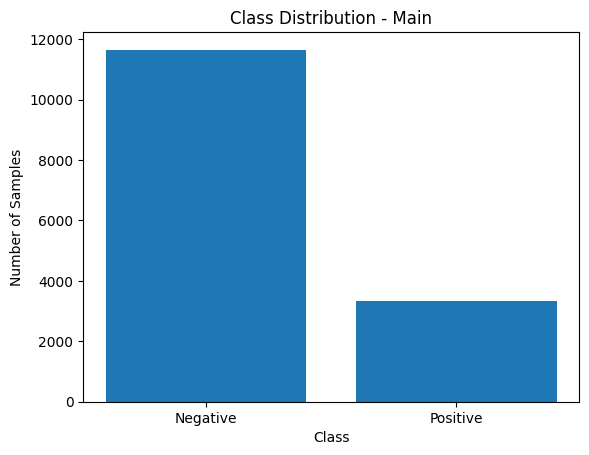

Main - Class: 0
Number of Samples: 11653
Prevalence: 77.69%

Main - Class: 1
Number of Samples: 3347
Prevalence: 22.31%



In [34]:
# Calculate and display prevalence for the training set
main_prevalence = (df_adm_notes_merged_sample['label'].sum() / len(df_adm_notes_merged_sample)) * 100
print("Training set prevalence (n = {:d}): {:.2f}%".format(len(df_adm_notes_merged_sample), main_prevalence))

datasets = {
    'Main': df_adm_notes_merged_sample
}

for dataset_name, dataset_df in datasets.items():
    # Calculate class distribution
    class_counts = dataset_df['label'].value_counts()

    # Calculate prevalence
    prevalence = class_counts / len(dataset_df) * 100

    # Visualize class distribution
    plt.figure()
    plt.bar(class_counts.index, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(f'Class Distribution - {dataset_name}')
    plt.xticks(class_counts.index, labels=['Negative', 'Positive'])  # Replace with actual class labels
    plt.show()

    # Print class distribution and prevalence
    for label, count, prev in zip(class_counts.index, class_counts, prevalence):
        print(f"{dataset_name} - Class:", label)
        print("Number of Samples:", count)
        print("Prevalence: {:.2f}%".format(prev))
        print()


dataset set prevalence (n = 6694): 50.00%


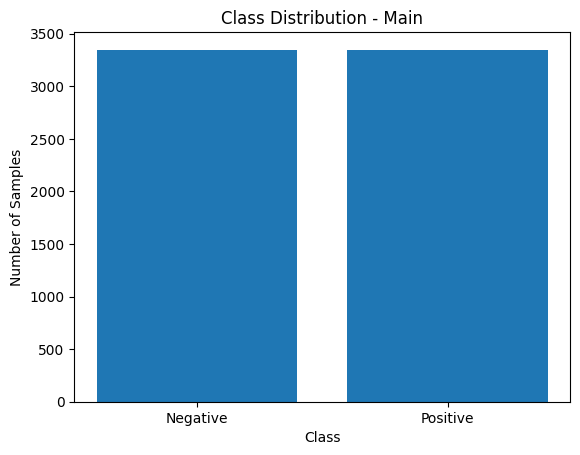

Main - Class: 0
Number of Samples: 3347
Prevalence: 50.00%

Main - Class: 1
Number of Samples: 3347
Prevalence: 50.00%



In [35]:
# Balancing the data prevalance using Sub sampling as it is efficient when computation power is low

pos_rows = df_adm_notes_merged_sample.label == 1
df_adm_notes_merged_pos = df_adm_notes_merged_sample.loc[pos_rows]
df_adm_notes_merged_neg = df_adm_notes_merged_sample.loc[~pos_rows]
df_adm_notes_merged_balanced = pd.concat([df_adm_notes_merged_pos, df_adm_notes_merged_neg.sample(n=len(df_adm_notes_merged_pos), random_state=42)], axis=0)
df_adm_notes_merged_balanced = df_adm_notes_merged_balanced.sample(n=len(df_adm_notes_merged_balanced), random_state=42).reset_index(drop=True)
prevalence = (df_adm_notes_merged_balanced.label.sum() / len(df_adm_notes_merged_balanced)) * 100
print("dataset set prevalence (n = {:d}): {:.2f}%".format(len(df_adm_notes_merged_balanced), prevalence))


datasets = {
    'Main': df_adm_notes_merged_balanced
}

for dataset_name, dataset_df in datasets.items():
    # Calculate class distribution
    class_counts = dataset_df['label'].value_counts()

    # Calculate prevalence
    prevalence = class_counts / len(dataset_df) * 100

    # Visualize class distribution
    plt.figure()
    plt.bar(class_counts.index, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(f'Class Distribution - {dataset_name}')
    plt.xticks(class_counts.index, labels=['Negative', 'Positive'])  # Replace with actual class labels
    plt.show()

    # Print class distribution and prevalence
    for label, count, prev in zip(class_counts.index, class_counts, prevalence):
        print(f"{dataset_name} - Class:", label)
        print("Number of Samples:", count)
        print("Prevalence: {:.2f}%".format(prev))
        print()


In [36]:
# Split the data into train, valid and test
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

df_train, remaining_df = train_test_split(df_adm_notes_merged_balanced, train_size=train_ratio, random_state=42)
df_train.reset_index(drop=True, inplace=True)
df_validation, df_test = train_test_split(remaining_df, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)
df_validation.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Print the sizes of the splits
print("Train Data:", df_train.shape[0])
print("Validation Data:", df_validation.shape[0])
print("Test Data:", df_test.shape[0])


Train Data: 4685
Validation Data: 1004
Test Data: 1005


In [37]:
# Calculate and display prevalence for the train, valid and test datasets
train_prevalence = (df_train['label'].sum() / len(df_train)) * 100
print("Training set prevalence (n = {:d}): {:.2f}%".format(len(df_train), train_prevalence))

valid_prevalence = (df_validation['label'].sum() / len(df_validation)) * 100
print("Validation set prevalence (n = {:d}): {:.2f}%".format(len(df_validation), valid_prevalence))

test_prevalence = (df_test['label'].sum() / len(df_test)) * 100
print("Test set prevalence (n = {:d}): {:.2f}%".format(len(df_test), test_prevalence))

print("All samples (n = {:d})".format(len(df_adm_notes_merged)))

Training set prevalence (n = 4685): 50.89%
Validation set prevalence (n = 1004): 45.32%
Test set prevalence (n = 1005): 50.55%
All samples (n = 167258)


In [41]:
# Step 1: Lowercasing
df_train['text'] = df_train['text'].fillna('').apply(lambda x: x.lower())
df_validation['text'] = df_validation['text'].fillna('').apply(lambda x: x.lower())
df_test['text'] = df_test['text'].fillna('').apply(lambda x: x.lower())

#Step 2 & 3: Removing Punctuation and Numbers and Words with Numbers
def remove_punctuation_and_numbers(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\b\d+\b|\w*\d\w*', '', text)
    return text

df_train['text'] = df_train['text'].apply(remove_punctuation_and_numbers)
df_validation['text'] = df_validation['text'].apply(remove_punctuation_and_numbers)
df_test['text'] = df_test['text'].apply(remove_punctuation_and_numbers)

# Step 4: Removing Newline Characters
df_train['text'] = df_train['text'].str.replace('\n', '').str.replace('\r', '')
df_validation['text'] = df_validation['text'].str.replace('\n', '').str.replace('\r', '')
df_test['text'] = df_test['text'].str.replace('\n', '').str.replace('\r', '')

# Step 5: Remove underscores from the text column
df_train['text'] = df_train['text'].str.replace('_', ' ')
df_validation['text'] = df_validation['text'].str.replace('_', ' ')
df_test['text'] = df_test['text'].str.replace('_', ' ')

# Step 6: Replace multiple spaces with a single space in the text column
df_train['text'] = df_train['text'].apply(lambda text: re.sub(r'\s+', ' ', text).strip())
df_validation['text'] = df_validation['text'].apply(lambda text: re.sub(r'\s+', ' ', text).strip())
df_test['text'] = df_test['text'].apply(lambda text: re.sub(r'\s+', ' ', text).strip())

In [45]:
# Create a copy of the pre-processed datasets for Clinical BERT model
df_train_bert = df_train.copy()
df_test_bert = df_test.copy()
df_validation_bert = df_validation.copy()

In [47]:
# Save the DataFrame as a CSV file for all models
df_train.to_csv("train_final.csv", index=False)
df_test.to_csv("test_final.csv", index=False)
df_validation.to_csv("validation_final.csv", index=False)

# Save the DataFrame as a CSV file for BERT model
df_train_bert.to_csv("train_bert_final.csv", index=False)
df_test_bert.to_csv("test_bert_final.csv", index=False)
df_validation_bert.to_csv("validation_bert_final.csv", index=False)